In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

%matplotlib notebook

In [2]:
def stepforward(z,zpower,frame):
    
    zalive = z.copy()
    uza = np.roll(zalive, 1, 0) #neighbour above
    dza = np.roll(zalive, -1, 0) #neighbour below
    rza = np.roll(zalive, -1, 1) #neighbour on right
    lza = np.roll(zalive, 1, 1) #neighbour on left
    
    up = np.roll(zpower, 1, 0) #neighbour above
    dp = np.roll(zpower, -1, 0) #neighbour below
    rp = np.roll(zpower, -1, 1) #neighbour on right
    lp = np.roll(zpower, 1, 1) #neighbour on left
    
    #Colonisation of dead systems
    #Empty systems randomly take value of one of neighbours (including dead systems)
    dead = (zalive==0)
    gen = np.random.rand(np.shape(z)[0],np.shape(z)[1])
    rand = np.floor(4*gen)
    znew = z.copy()
    znew[rand==0] = uza[rand==0] 
    znew[rand==1] = dza[rand==1]
    znew[rand==2] = rza[rand==2]
    znew[rand==3] = lza[rand==3] 
    z[dead] = znew[dead]
    zapower = zpower.copy()  
    zpn = zpower.copy()
    zapower[rand==0] = up[rand==0] 
    zapower[rand==1] = dp[rand==1]
    zapower[rand==2] = rp[rand==2]
    zapower[rand==3] = lp[rand==3] 
    zpower[dead] = zapower[dead]
    
    #Tech level system
    #Randomly choose neighbour
    #If tech level higher they either colonise you or raise you up based on closeness of colour
    #If lower you are not affected
    loss = ((zpn-zapower)<0)
    cdiff = 1/500*np.abs(zalive-znew)
    #if random number is less than colour difference there is peace 
    zpower[np.logical_and(loss,(gen<cdiff))] = zapower[np.logical_and(loss,(gen<cdiff))]
    #else there is war and the culture is replaced
    z[np.logical_and(loss,(gen>cdiff))] = znew[np.logical_and(loss,(gen>cdiff))]
    zpower[np.logical_and(loss,(gen>cdiff))] = zapower[np.logical_and(loss,(gen>cdiff))]
    
    #Cultural drift 
    #Every 150 years 0.001% chance that system will deviate enough to be considered something new to the galaxy and be strong 
    #enough to fight for their existence
    alive = (zalive>0)
    rand = np.floor(1e5*gen)
    znew = z.copy()
    znew[rand==0] = 1e5*gen[rand==0]
    z[alive] = znew[alive]
    #zpower[np.logical_and(rand==0,alive)] += 1e5*gen[np.logical_and(rand==0,alive)]
    
    trigger = np.exp(frame/1e5)*1e6
    #Alien civilisations rise
    znew = z.copy()
    rand = np.floor(trigger*gen)
    znew[rand==0] = trigger*gen[rand==0]
    z[dead] = znew[dead]
    zpn[rand==0] = trigger*gen[rand==0]
    zpower[dead] = zpn[dead]
    
    #Inovation
    gen = np.random.rand(np.shape(z)[0],np.shape(z)[1])
    rand = np.floor(trigger*gen)
    zpn = zpower.copy()
    zpower[np.logical_and(rand==0,alive)] += np.exp(frame)*1e6*gen[np.logical_and(rand==0,alive)]
    
    return z,zpower

<IPython.core.display.Javascript object>


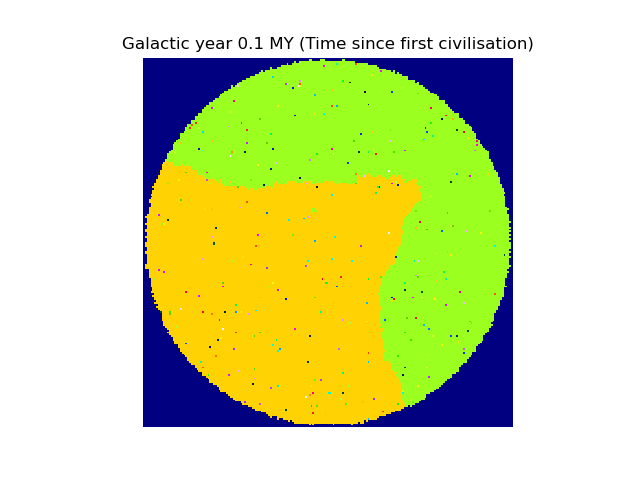

/tmp/ipykernel_56322/1328958560.py:68: RuntimeWarning: overflow encountered in double_scalars
  zpower[np.logical_and(rand==0,alive)] += np.exp(frame)*1e6*gen[np.logical_and(rand==0,alive)]
/tmp/ipykernel_56322/1328958560.py:68: RuntimeWarning: overflow encountered in exp
  zpower[np.logical_and(rand==0,alive)] += np.exp(frame)*1e6*gen[np.logical_and(rand==0,alive)]
/tmp/ipykernel_56322/1328958560.py:37: RuntimeWarning: invalid value encountered in subtract
  loss = ((zpn-zapower)<0)


In [8]:
n = 1
rows = 1
cols = 1
fig, ax = plt.subplots(rows,cols) 
if (n != 1):
    axflat = ax.flatten()

# 1000x1000 is about what I can easily deal with. So each bit represents an area 100x100 light years big. So typically
# contains about 1500 star systems!
nx, ny = (1000, 1000)
nx, ny = (200, 200)

x = np.round(np.linspace(0, nx, nx+1))
y = np.round(np.linspace(0, ny, ny+1))
z = np.floor(2*np.random.rand(ny,nx))
z = 0*z 
#z[int(3*nx/4),int(3*ny/4)] = 1
#zpower = z.copy()


x = np.round(np.linspace(0, nx, nx))
y = np.round(np.linspace(0, ny, ny))
X,Y = np.meshgrid(x,y)
dist = np.sqrt(np.abs(Y - np.max(Y)/2)**2 + np.abs(X - np.max(X)/2)**2)
bc = (dist>(nx/2 -1))

global zn
global znew
global zold
zn = []
znew = []
znpower = []
for i in range(n):
    zn.append(z.copy())
    znpower.append(zpower.copy())
znew = zn.copy()
zold = zn.copy()
    
quads = []
if (n != 1):
    for i in range(n):
        quads.append(axflat[i].pcolormesh(x,y,zn[i],shading='auto', cmap=cm.gist_ncar))
        axflat[i].set_aspect('equal', adjustable='box')
        axflat[i].set_axis_off()
        #axflat[i].set_title('GOL{}'.format(i+1))
else:
    quads.append(ax.pcolormesh(x,y,zn[i],shading='auto', cmap=cm.gist_ncar)) #cm.Greys
    ax.set_aspect('equal', adjustable='box')
    ax.set_axis_off()
    ax.set_title('Years: 0')

#bug tester
# for i in range(n):  
#     for j in range(200):
#         zn[i] = stepforward(zn[i],code[i])
#     quads[i].set_array(zn[i])
#     quads[i].set_clim(0,1)
#     zn[i][zn[i]<0] = 0
    
        
def animate(frame):
    global zn
    global znew
    global zold
    for i in range(n):
        zn[i],znpower[i] = stepforward(zn[i],znpower[i],frame)
        quads[i].set_array(zn[i])
        #quads[i].set_array(znpower[i])
        quads[i].set_clim(0,1)
        zn[i][zn[i]<0] = 0
        
        #BC (Edge of milky way)
        zn[i][bc] = 0
        znpower[i][bc] = 0
        
        ax.set_title('Galactic year {:.1f} MY (Time since first civilisation)'.format(frame*5*150 /1e6))
            
    return quads

anim = animation.FuncAnimation(fig,animate,frames=60*30,interval=50,blit=False,repeat=True)
anim.save('galacticConquest.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
plt.show()

In [4]:
#Pure unopposed expansion
def stepforward(z,zpower):
    
    zalive = z.copy()
    uza = np.roll(zalive, 1, 0) #neighbour above
    dza = np.roll(zalive, -1, 0) #neighbour below
    rza = np.roll(zalive, -1, 1) #neighbour on right
    lza = np.roll(zalive, 1, 1) #neighbour on left
    #Colonisation of dead systems
    #Empty systems randomly take value of one of neighbours (including dead systems)
    dead = (zalive==0)
    gen = np.random.rand(np.shape(z)[0],np.shape(z)[1])
    rand = np.floor(4*gen)
    znew = z.copy()
    znew[rand==0] = uza[rand==0] 
    znew[rand==1] = dza[rand==1]
    znew[rand==2] = rza[rand==2]
    znew[rand==3] = lza[rand==3] 
    z[dead] = znew[dead]
    
    return z,zpower